## Data Preparation

In [1]:
import os
import anndata
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score


import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pprint
import warnings

In [2]:
# Turn off warnings
warnings.filterwarnings('ignore')

In [ ]:
def make_classif_df(data: anndata.AnnData, markers_names: dict[int:str]=None) -> pd.DataFrame:
    """
    Function to create a DataFrame for classification from anndata object

    Parameters
    ----------
    data : anndata.AnnData
        anndata object with 'obs' table with columns 'image' and 'cell_labels' 
        and 'layers' with 'exprs' table.
    markers_names : dict[int:str], optional
        a dictionary mapping marker indices to markers names, by default None

    Returns
    -------
    pd.DataFrame
        a DataFrame with the features (markers experssion) and cell labels for classification
    """
    features = np.arcsinh(data.layers['exprs'] / 5.0)
    labels = data.obs['cell_labels'].astype('category').cat.codes.values
    cell_names = data.obs['cell_labels'].values
    
    df = pd.DataFrame(features)
    df['labels'] = labels
    df['cell_names'] = cell_names
    if markers_names:
        df.columns = [markers_names[i] for i in range(df.shape[1] - 2)] + ['labels', 'cell_names']

    return df

In [3]:
TRAIN_DATA_PATH = './data/train'
TEST_DATA_PATH = './data/test'
ORIGINAL_IMAGE_DATA_SUBDIR = 'images_masks'
ORIGINAL_MASKS_SUBDIR = 'masks'
ORIGINAL_IMAGES_SUBDIR = 'img'

if TRAIN_DATA_PATH is None:
    raise ValueError('Please set PATH_TO_FOLDER to a path with unzipped training data.')

ANNDATA_PATH = 'adata.h5ad'
TRAIN_ANNDATA_PATH = os.path.join(TRAIN_DATA_PATH, f'train_{ANNDATA_PATH}')
TRAIN_IMAGE_DATA_DIR = os.path.join(TRAIN_DATA_PATH, ORIGINAL_IMAGE_DATA_SUBDIR)
TRAIN_IMAGE_DATA_IMAGES = os.path.join(TRAIN_IMAGE_DATA_DIR, ORIGINAL_IMAGES_SUBDIR)
TRAIN_IMAGE_DATA_MASKS = os.path.join(TRAIN_IMAGE_DATA_DIR, ORIGINAL_MASKS_SUBDIR)

TEST_ANNDATA_PATH = os.path.join(TEST_DATA_PATH, f'test_{ANNDATA_PATH}')
TEST_IMAGE_DATA_DIR = os.path.join(TEST_DATA_PATH, ORIGINAL_IMAGE_DATA_SUBDIR)
TEST_IMAGE_DATA_IMAGES = os.path.join(TEST_IMAGE_DATA_DIR, ORIGINAL_IMAGES_SUBDIR)
TEST_IMAGE_DATA_MASKS = os.path.join(TEST_IMAGE_DATA_DIR, ORIGINAL_MASKS_SUBDIR)

In [4]:
train_anndata = anndata.read_h5ad(TRAIN_ANNDATA_PATH)
train_anndata.var.index = train_anndata.var.index.astype(int)

test_anndata = anndata.read_h5ad(TEST_ANNDATA_PATH)
test_anndata.var.index = test_anndata.var.index.astype(int)

markers_names_map = train_anndata.var['marker'].to_dict()
train_df = make_classif_df(train_anndata, markers_names_map)
test_df = make_classif_df(test_anndata, markers_names_map)
train_df

,MPO,HistoneH3,SMA,CD16,CD38,HLADR,CD27,CD15,CD45RA,CD163,...,CD4,CD14,Ecad,CD303,CD206,cleavedPARP,DNA1,DNA2,labels,cell_names
0,0.000000,0.356404,0.100361,0.250455,0.102820,0.624800,0.080672,0.090959,0.105551,0.559954,...,0.324592,0.491246,0.154856,0.000000,0.665901,0.084753,0.847186,0.923356,6,MacCD163
1,0.027181,0.462005,0.225477,0.100934,0.120873,0.141697,0.083864,0.020021,0.148059,0.065923,...,0.268438,0.333803,0.368555,0.013774,0.148382,0.023722,0.885503,0.954479,7,Mural
2,0.033175,0.435122,0.275759,0.342161,0.091580,0.733683,0.000721,0.112340,0.244849,0.342814,...,0.380643,0.646955,0.341996,0.080635,0.435028,0.003028,0.796686,0.855100,4,DC
3,0.033175,0.227001,0.112406,0.231138,0.102567,0.396472,0.129685,0.050009,0.238727,0.196804,...,0.442884,0.479728,0.439499,0.039230,0.188186,0.046602,0.690920,0.789117,11,Tumor
4,0.027496,0.428921,0.177540,0.099366,0.082474,0.295517,0.019625,0.041701,0.183543,0.248609,...,0.285137,0.451058,0.460960,0.012313,0.321038,0.074387,0.824742,0.902713,11,Tumor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253428,0.044771,0.972477,0.522792,0.452190,0.169862,0.326357,0.326295,0.238182,0.261421,0.157233,...,0.163447,0.313110,0.273018,0.161974,0.106068,0.006945,0.783990,0.858377,7,Mural
253429,0.029884,0.718375,0.525726,0.140125,0.107772,0.086967,0.111346,0.029300,0.080419,0.063402,...,0.051260,0.246816,0.237808,0.046073,0.040698,0.000000,0.828517,0.906893,7,Mural
253430,0.022175,0.655988,0.062127,0.497294,0.451769,0.677491,0.284738,0.049750,0.091045,0.203722,...,0.365527,0.557114,0.281801,0.197656,0.044868,0.020502,0.779303,0.856565,3,CD8
253431,0.030184,0.765888,0.508173,0.160870,0.080647,0.242943,0.080070,0.053107,0.102526,0.033648,...,0.048917,0.294732,0.157751,0.009497,0.018119,0.016794,0.856041,0.931607,7,Mural


In [5]:
X_train = train_df.drop(['labels', 'cell_names'], axis=1)
y_train = train_df['labels']

X_test = test_df.drop(['labels', 'cell_names'], axis=1)
y_test = test_df['labels']

In [6]:
labels_names = train_df.set_index('labels')['cell_names'].to_dict()
# sorted list of cell names by label
cell_names_by_label = [labels_names[label] for label in sorted(labels_names.keys())]
print(cell_names_by_label)

['B', 'BnT', 'CD4', 'CD8', 'DC', 'HLADR', 'MacCD163', 'Mural', 'NK', 'Neutrophil', 'Treg', 'Tumor', 'pDC', 'plasma']


## Multiclass Logistic Regression

{'estimator': [LogisticRegression(),
               LogisticRegression(),
               LogisticRegression(),
               LogisticRegression(),
               LogisticRegression()],
 'fit_time': array([7.97272801, 9.60403824, 7.84826279, 8.13770795, 6.86553907]),
 'score_time': array([0.07463884, 0.05580091, 0.05274391, 0.06523013, 0.06103802]),
 'test_balanced_accuracy': array([0.83764097, 0.83225996, 0.83901565, 0.83946641, 0.83942611]),
 'test_f1_macro': array([0.85815113, 0.85185938, 0.85667694, 0.85391669, 0.85962021]),
 'test_precision_macro': array([0.88723065, 0.87894483, 0.88126684, 0.87337052, 0.88648453]),
 'test_recall_macro': array([0.83764097, 0.83225996, 0.83901565, 0.83946641, 0.83942611])}
              precision    recall  f1-score   support

           B       0.89      0.87      0.88       373
         BnT       0.85      0.88      0.87       649
         CD4       0.88      0.86      0.87      1324
         CD8       0.92      0.94      0.93      2272
         

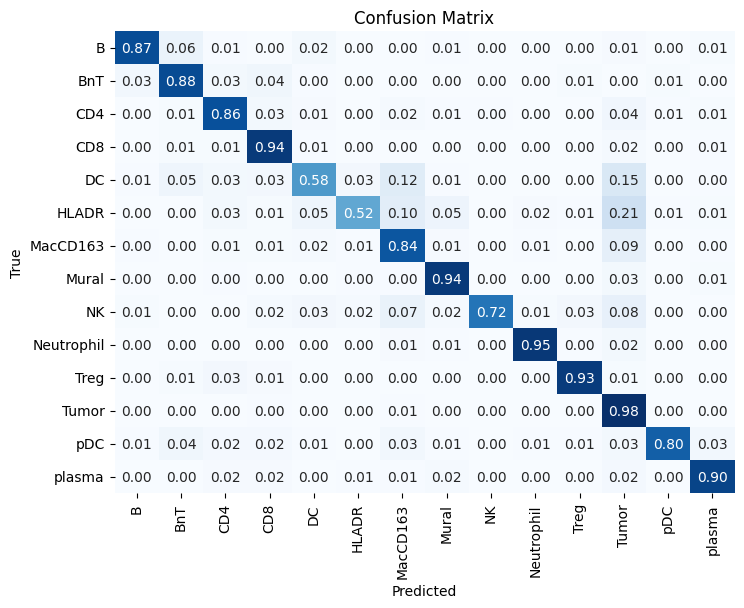

B -- AUC: 1.00
BnT -- AUC: 1.00
CD4 -- AUC: 1.00
CD8 -- AUC: 1.00
DC -- AUC: 0.98
HLADR -- AUC: 0.98
MacCD163 -- AUC: 0.99
Mural -- AUC: 1.00
NK -- AUC: 1.00
Neutrophil -- AUC: 1.00
Treg -- AUC: 1.00
Tumor -- AUC: 0.99
pDC -- AUC: 0.99
plasma -- AUC: 1.00


In [10]:
log_params = {
    'penalty': 'l2',
    'dual': False, 
    'tol': 0.0001, 
    'C': 1.0, 
    'fit_intercept': True, 
    'intercept_scaling': 1, 
    'class_weight': None, 
    'random_state': None, 
    'solver': 'lbfgs', 
    'max_iter': 100, 
    'multi_class': 'auto', 
    'verbose': 0, 
    'warm_start': False, 
    'n_jobs': None, 
    'l1_ratio': None
}

log_model = LogisticRegression(**log_params)

skf = StratifiedKFold(n_splits=5)

# for mulit class problem it is good to take those metrics with some weighting 
scoring = ['precision_macro', 'recall_macro', 'balanced_accuracy', 'f1_macro']
scores = cross_validate(log_model, X_train, y_train,
                        scoring=scoring, cv=skf,
                        return_estimator=True)

pprint.pprint(scores)
# refit the model with data 
log_model.fit(X_train, y_train)

log_predictions = log_model.predict(X_train)
log_proba = log_model.predict_proba(X_train)

print(classification_report(y_test, log_predictions, target_names=cell_names_by_label))

cm = confusion_matrix(y_test, log_predictions, normalize='true')
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(ticks=np.arange(len(np.unique(y_test)))+0.5, labels=cell_names_by_label, rotation=90)
plt.yticks(ticks=np.arange(len(np.unique(y_test)))+0.5, labels=cell_names_by_label, rotation=0)
plt.show()

# per class ROC AUC
for i in range(len(cell_names_by_label)):
    y_true = y_test == i
    y_score = log_proba[:, i]
    print(f'{cell_names_by_label[i]} -- AUC: {roc_auc_score(y_true, y_score):.2f}')


In [19]:
# test

preds = log_model.predict(X_test)
probs = log_model.predict_proba(X_test)

print(classification_report(y_test, preds, target_names=cell_names_by_label))

pred_labels = [cell_names_by_label[label] for label in preds]
true_labels = [cell_names_by_label[label] for label in y_test]

df_pred_logmodel = pd.DataFrame(probs, columns=cell_names_by_label)
df_pred_logmodel['predicted_label'] = pred_labels
df_pred_logmodel['true_label'] = true_labels

df_pred_logmodel.to_csv('logreg_predictions.tsv', sep='\t', index=False)

              precision    recall  f1-score   support

           B       0.92      0.87      0.89      2767
         BnT       0.83      0.88      0.86      3341
         CD4       0.87      0.88      0.88      6139
         CD8       0.91      0.92      0.91      6890
          DC       0.75      0.54      0.63      2048
       HLADR       0.70      0.55      0.61      1627
    MacCD163       0.83      0.84      0.84      6482
       Mural       0.90      0.96      0.93      8977
          NK       0.88      0.66      0.75       498
  Neutrophil       0.93      0.92      0.92      2633
        Treg       0.96      0.88      0.92      1903
       Tumor       0.96      0.97      0.96     41456
         pDC       0.86      0.80      0.83       843
      plasma       0.90      0.93      0.91      4199

    accuracy                           0.92     89803
   macro avg       0.87      0.83      0.85     89803
weighted avg       0.91      0.92      0.91     89803



## Random Forest

{'estimator': [RandomForestClassifier(class_weight='balanced', max_features='auto',
                       n_estimators=1000, n_jobs=-1, random_state=0),
               RandomForestClassifier(class_weight='balanced', max_features='auto',
                       n_estimators=1000, n_jobs=-1, random_state=0),
               RandomForestClassifier(class_weight='balanced', max_features='auto',
                       n_estimators=1000, n_jobs=-1, random_state=0),
               RandomForestClassifier(class_weight='balanced', max_features='auto',
                       n_estimators=1000, n_jobs=-1, random_state=0),
               RandomForestClassifier(class_weight='balanced', max_features='auto',
                       n_estimators=1000, n_jobs=-1, random_state=0)],
 'fit_time': array([214.54901981, 217.41738176, 214.84038305, 219.03103113,
       210.48293781]),
 'score_time': array([0.919312  , 1.07956505, 1.13146901, 1.123317  , 1.11513901]),
 'test_balanced_accuracy': array([0.85356716, 

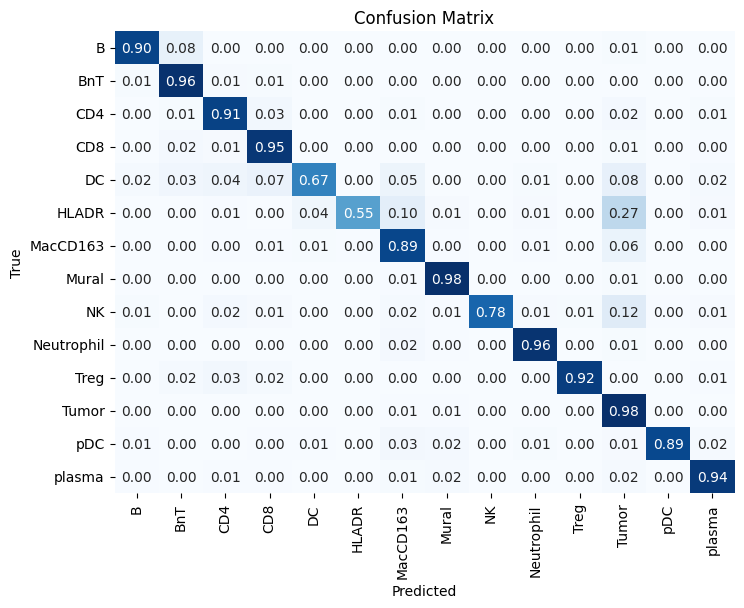

B -- AUC: 1.00
BnT -- AUC: 1.00
CD4 -- AUC: 1.00
CD8 -- AUC: 1.00
DC -- AUC: 0.99
HLADR -- AUC: 0.99
MacCD163 -- AUC: 1.00
Mural -- AUC: 1.00
NK -- AUC: 1.00
Neutrophil -- AUC: 1.00
Treg -- AUC: 1.00
Tumor -- AUC: 1.00
pDC -- AUC: 1.00
plasma -- AUC: 1.00


In [12]:
from sklearn.ensemble import RandomForestClassifier

rf_params = {
    'n_estimators': 1000,
    'criterion': 'gini',
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'min_weight_fraction_leaf': 0.0,
    'max_features': 'auto',
    'max_leaf_nodes': None,
    'min_impurity_decrease': 0.0,
    'bootstrap': True,
    'oob_score': False,
    'n_jobs': -1,
    'random_state': 0,
    'verbose': 0,
    'warm_start': False,
    'class_weight': 'balanced',
}

rf_model = RandomForestClassifier(**rf_params)
skf = StratifiedKFold(n_splits=5)

scoring = ['precision_macro', 'recall_macro', 'balanced_accuracy', 'f1_macro']
scores = cross_validate(rf_model, X_train, y_train, scoring=scoring, cv=skf, return_estimator=True)

pprint.pprint(scores)

rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_proba = rf_model.predict_proba(X_test)

print(classification_report(y_test, rf_predictions, target_names=cell_names_by_label))

cm = confusion_matrix(y_test, rf_predictions, normalize='true')
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(ticks=np.arange(len(np.unique(y_test)))+0.5, labels=cell_names_by_label, rotation=90)
plt.yticks(ticks=np.arange(len(np.unique(y_test)))+0.5, labels=cell_names_by_label, rotation=0)
plt.show()

# per class ROC AUC
for i in range(len(cell_names_by_label)):
    y_true = y_test == i
    y_score = rf_proba[:, i]
    print(f'{cell_names_by_label[i]} -- AUC: {roc_auc_score(y_true, y_score):.2f}')

In [13]:
pred_labels = [cell_names_by_label[label] for label in rf_predictions]
true_labels = [cell_names_by_label[label] for label in y_test]

df_pred_rfmodel = pd.DataFrame(rf_proba, columns=cell_names_by_label)
df_pred_rfmodel['predicted_label'] = pred_labels
df_pred_rfmodel['true_label'] = true_labels

df_pred_rfmodel.to_csv('rf_predictions.tsv', sep='\t', index=False)

## XGBoost

              precision    recall  f1-score   support

           B       0.96      0.90      0.93      2767
         BnT       0.88      0.95      0.91      3341
         CD4       0.92      0.92      0.92      6139
         CD8       0.92      0.95      0.93      6890
          DC       0.82      0.74      0.78      2048
       HLADR       0.78      0.69      0.73      1627
    MacCD163       0.90      0.87      0.88      6482
       Mural       0.96      0.98      0.97      8977
          NK       0.93      0.84      0.88       498
  Neutrophil       0.95      0.95      0.95      2633
        Treg       0.97      0.94      0.95      1903
       Tumor       0.97      0.97      0.97     41456
         pDC       0.87      0.92      0.89       843
      plasma       0.94      0.95      0.95      4199

    accuracy                           0.94     89803
   macro avg       0.91      0.90      0.90     89803
weighted avg       0.94      0.94      0.94     89803



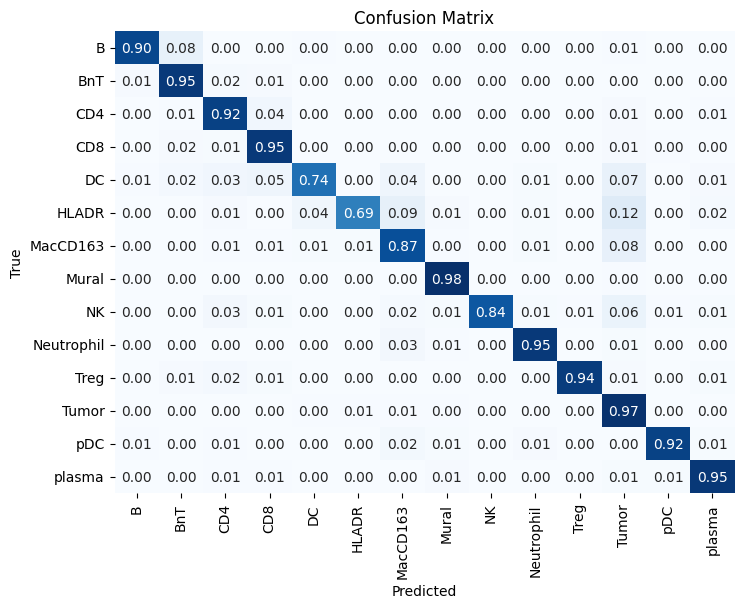

B -- AUC: 1.00
BnT -- AUC: 1.00
CD4 -- AUC: 1.00
CD8 -- AUC: 1.00
DC -- AUC: 1.00
HLADR -- AUC: 0.99
MacCD163 -- AUC: 1.00
Mural -- AUC: 1.00
NK -- AUC: 1.00
Neutrophil -- AUC: 1.00
Treg -- AUC: 1.00
Tumor -- AUC: 1.00
pDC -- AUC: 1.00
plasma -- AUC: 1.00


In [14]:
from xgboost import XGBClassifier

# declare parameters
xgb_params = {
    'objective': 'multi:softmax',
    'max_depth': 6,
    'lambda': 1,
    'learning_rate': 0.3,
    'n_estimators': 1000,
    'seed': 0,
}
            
xgb_model = XGBClassifier(**xgb_params)

skf = StratifiedKFold(n_splits=5)

# for mulit class problem it is good to take those metrics with some weighting 
scoring = ['precision_macro', 'recall_macro', 'balanced_accuracy', 'f1_macro']
# scores = cross_validate(xgb_model, X_train, y_train,
#                         scoring=scoring, cv=skf,
#                         return_estimator=True)

# pprint.pprint(scores)
# refit the model with data 
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)
xgb_proba = xgb_model.predict_proba(X_test)

print(classification_report(y_test, xgb_predictions, target_names=cell_names_by_label))

cm = confusion_matrix(y_test, xgb_predictions, normalize='true')
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(ticks=np.arange(len(np.unique(y_test)))+0.5, labels=cell_names_by_label, rotation=90)
plt.yticks(ticks=np.arange(len(np.unique(y_test)))+0.5, labels=cell_names_by_label, rotation=0)
plt.show()

# per class ROC AUC
for i in range(len(cell_names_by_label)):
    y_true = y_test == i
    y_score = xgb_proba[:, i]
    print(f'{cell_names_by_label[i]} -- AUC: {roc_auc_score(y_true, y_score):.2f}')

In [15]:
# test

preds = xgb_model.predict(X_test)
probs = xgb_model.predict_proba(X_test)

print(classification_report(y_test, preds, target_names=cell_names_by_label))

pred_labels = [cell_names_by_label[label] for label in preds]
true_labels = [cell_names_by_label[label] for label in y_test]

df_pred_xgb = pd.DataFrame(probs, columns=cell_names_by_label)
df_pred_xgb['predicted_label'] = pred_labels
df_pred_xgb['true_label'] = true_labels

df_pred_xgb.to_csv('xgb_predictions.tsv', sep='\t', index=False)

              precision    recall  f1-score   support

           B       0.96      0.90      0.93      2767
         BnT       0.88      0.95      0.91      3341
         CD4       0.92      0.92      0.92      6139
         CD8       0.92      0.95      0.93      6890
          DC       0.82      0.74      0.78      2048
       HLADR       0.78      0.69      0.73      1627
    MacCD163       0.90      0.87      0.88      6482
       Mural       0.96      0.98      0.97      8977
          NK       0.93      0.84      0.88       498
  Neutrophil       0.95      0.95      0.95      2633
        Treg       0.97      0.94      0.95      1903
       Tumor       0.97      0.97      0.97     41456
         pDC       0.87      0.92      0.89       843
      plasma       0.94      0.95      0.95      4199

    accuracy                           0.94     89803
   macro avg       0.91      0.90      0.90     89803
weighted avg       0.94      0.94      0.94     89803



## MLP 

{'estimator': [MLPClassifier(),
               MLPClassifier(),
               MLPClassifier(),
               MLPClassifier(),
               MLPClassifier()],
 'fit_time': array([245.19433999, 193.83161783, 212.03404117, 194.38570595,
       174.69107127]),
 'score_time': array([0.09230113, 0.09577918, 0.09135485, 0.10574389, 0.09176588]),
 'test_balanced_accuracy': array([0.86755448, 0.89214988, 0.88342769, 0.85880025, 0.71757915]),
 'test_f1_macro': array([0.84421023, 0.89376871, 0.87494615, 0.84779034, 0.64824384]),
 'test_precision_macro': array([0.83007064, 0.89662687, 0.87300533, 0.85246267, 0.63977857]),
 'test_recall_macro': array([0.86755448, 0.89214988, 0.88342769, 0.85880025, 0.71757915])}
              precision    recall  f1-score   support

           B       0.95      0.90      0.92      2767
         BnT       0.86      0.94      0.90      3341
         CD4       0.93      0.89      0.91      6139
         CD8       0.91      0.93      0.92      6890
          DC     

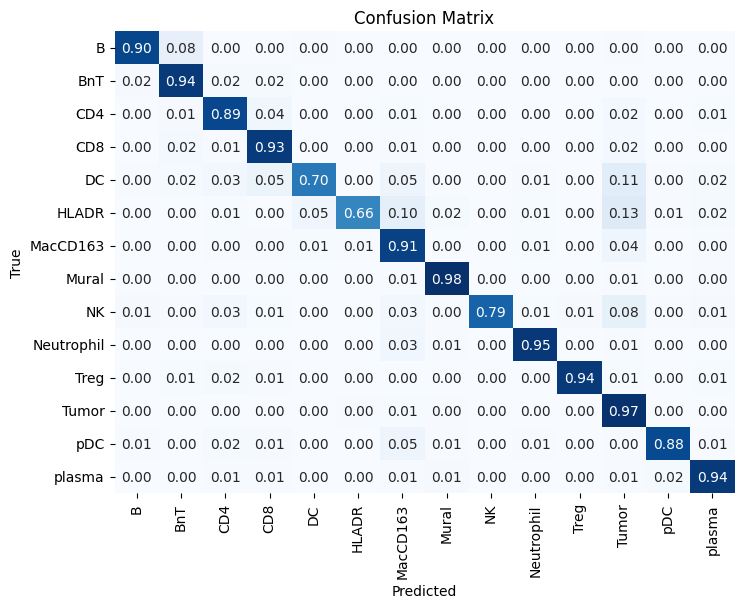

B -- AUC: 1.00
BnT -- AUC: 1.00
CD4 -- AUC: 1.00
CD8 -- AUC: 1.00
DC -- AUC: 1.00
HLADR -- AUC: 0.99
MacCD163 -- AUC: 1.00
Mural -- AUC: 1.00
NK -- AUC: 1.00
Neutrophil -- AUC: 1.00
Treg -- AUC: 1.00
Tumor -- AUC: 1.00
pDC -- AUC: 1.00
plasma -- AUC: 1.00


In [22]:
from sklearn.neural_network import MLPClassifier

mlp_params = {
    'hidden_layer_sizes': (100,), 
    'activation': 'relu', 
    'solver': 'adam', 
    'alpha': 0.0001, 
    'batch_size': 'auto', 
    'learning_rate': 'constant', 
    'learning_rate_init': 0.001, 
    'power_t': 0.5,
    'max_iter': 200,
    'shuffle': True,
    'random_state': 0,
    'tol': 0.0001,
    'verbose': False,
    'warm_start': False,
    'momentum': 0.9,
    'nesterovs_momentum': True,
    'early_stopping': False,
    'validation_fraction': 0.1,
    'beta_1': 0.9,
    'beta_2': 0.999,
    'epsilon': 1e-08,
    'n_iter_no_change': 10,
    'max_fun': 15000
}

mlp_model = MLPClassifier(**mlp_params)
skf = StratifiedKFold(n_splits=5)

# for mulit class problem it is good to take those metrics with some weighting 
scoring = ['precision_macro', 'recall_macro', 'balanced_accuracy', 'f1_macro']
scores = cross_validate(mlp_model, X_train, y_train,
                        scoring=scoring, cv=skf,
                        return_estimator=True)

pprint.pprint(scores)
# refit the model with data 
mlp_model.fit(X_train, y_train)
mlp_predictions = mlp_model.predict(X_test)
mlp_proba = mlp_model.predict_proba(X_test)

print(classification_report(y_test, mlp_predictions, target_names=cell_names_by_label))

cm = confusion_matrix(y_test, mlp_predictions, normalize='true')
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(ticks=np.arange(len(np.unique(y_test)))+0.5, labels=cell_names_by_label, rotation=90)
plt.yticks(ticks=np.arange(len(np.unique(y_test)))+0.5, labels=cell_names_by_label, rotation=0)
plt.show()

# per class ROC AUC
for i in range(len(cell_names_by_label)):
    y_true = y_test == i
    y_score = mlp_proba[:, i]
    print(f'{cell_names_by_label[i]} -- AUC: {roc_auc_score(y_true, y_score):.2f}')

In [23]:
# test

preds = mlp_model.predict(X_test)
probs = mlp_model.predict_proba(X_test)

print(classification_report(y_test, preds, target_names=cell_names_by_label))

pred_labels = [cell_names_by_label[label] for label in preds]
true_labels = [cell_names_by_label[label] for label in y_test]

df_pred_mlp = pd.DataFrame(probs, columns=cell_names_by_label)
df_pred_mlp['predicted_label'] = pred_labels
df_pred_mlp['true_label'] = true_labels

df_pred_mlp.to_csv('mlp_predictions.tsv', sep='\t', index=False)

              precision    recall  f1-score   support

           B       0.95      0.90      0.92      2767
         BnT       0.86      0.94      0.90      3341
         CD4       0.93      0.89      0.91      6139
         CD8       0.91      0.93      0.92      6890
          DC       0.82      0.70      0.76      2048
       HLADR       0.82      0.66      0.73      1627
    MacCD163       0.86      0.91      0.89      6482
       Mural       0.96      0.98      0.97      8977
          NK       0.90      0.79      0.84       498
  Neutrophil       0.94      0.95      0.94      2633
        Treg       0.96      0.94      0.95      1903
       Tumor       0.97      0.97      0.97     41456
         pDC       0.82      0.88      0.85       843
      plasma       0.91      0.94      0.93      4199

    accuracy                           0.94     89803
   macro avg       0.90      0.88      0.89     89803
weighted avg       0.94      0.94      0.94     89803

